# **Part(A) - RL**

## Import Required Libaries

In [ ]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import LSTM, Dense
from keras.models import load_model

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(tf.__version__)

2.17.1


## Constants

In [ ]:
# Environment
GRID_SIZE = (60, 60)
TARGET_RADIUS = 4
MAX_EPISODES = 10000
MAX_STEPS = 500

# LSTM MODEL
HISTORY_LENGTH = 25

In [ ]:
# D3QN Agent NN
REPLAY_MEMORY_CAPACITY = 10000
MINIBATCH_SIZE = 32
TARGET_NETWORK_UPDATE_RATE = 0.008
DISCOUNT_FACTOR = 0.96
Q_NETWORK_LEARNING_RATE = 0.0005
PRE_TRAINING_ROUNDS = 1000

## Predefined environments


In [ ]:
ENVIRONMENTS = [
    {
      'start_pos': (10, 57),
      'target_pos': (30, 5),
      'obstacles': [
          # Static Obstacles
          {'pos': (38, 27), 'rad': 5},
          {'pos': (18, 26), 'rad': 11},
          {'pos': (48, 40), 'rad': 6},
          # Dynamic Obstacles
          {'pos': [35, 47], 'rad': 2, 'velocity': [-1, 0], 'range': (5, 35)},  # Moves along X-axis
          {'pos': [30, 32], 'rad': 2, 'velocity': [1, 1], 'range': ([30, 39], [32, 41])},  # Moves along both X and Y
          {'pos': [20, 12], 'rad': 2, 'velocity': [2, 0], 'range': (20, 40)}  # Moves along X-axis
      ]
    }
]

## `LSTM` Model

In [ ]:
model = Sequential([
    LSTM(128, input_shape=(25, 2), return_sequences=True),
    LSTM(128, return_sequences=True),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(2, activation='linear')
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 25, 128)             │          67,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 25, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (None, 25, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 273,090 (1.04 MB)

 Trainable params: 273,090 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

### Generate and Plot Obstacle Trajectories for Checking

In [ ]:
def generate_obstacle_trajectory(initial_pos, velocity, range_limits, steps=10):
    """
    Generates the trajectory of an obstacle based on its initial position, velocity, and movement range.

    Parameters:
    - initial_pos: List of initial [x, y] coordinates.
    - velocity: List of [vx, vy] velocities.
    - range_limits: Movement range. Can be either 1D or 2D range.
      - 1D range: (min_x, max_x) for x-axis movement.
      - 2D range: ([min_x, max_x], [min_y, max_y]) for 2D movement.
    - steps: Number of steps to simulate the trajectory.

    Returns:
    - trajectory: A list of [x, y] positions representing the trajectory.
    """
    obs_trajectory = []
    pos = np.array(initial_pos)
    vel = np.array(velocity)

    for _ in range(steps):
        obs_trajectory.append(pos.copy())

        if isinstance(range_limits[0], int):
            min_x, max_x = range_limits
            if pos[0] + vel[0] > max_x or pos[0] + vel[0] < min_x:
                vel[0] *= -1
        else:
            min_x, max_x = range_limits[0]
            min_y, max_y = range_limits[1]
            if pos[0] + vel[0] > max_x or pos[0] + vel[0] < min_x:
                vel[0] *= -1
            if pos[1] + vel[1] > max_y or pos[1] + vel[1] < min_y:
                vel[1] *= -1

        # Update position
        pos += vel

    return np.array(obs_trajectory)


def plot_trajectory(trajectory, obstacle_num):
    """
    Plots the trajectory of an obstacle.

    Parameters:
    - trajectory: Numpy array of [x, y] positions representing the trajectory.
    - obstacle_num: Number of the obstacle (for labeling).
    """

    plt.plot(trajectory[:, 0], trajectory[:, 1], marker='o', label=f'Obstacle {obstacle_num}')
    plt.scatter(trajectory[0, 0], trajectory[0, 1], color='red', zorder=5, label=f'Start Obstacle {obstacle_num}')  # mark starting point

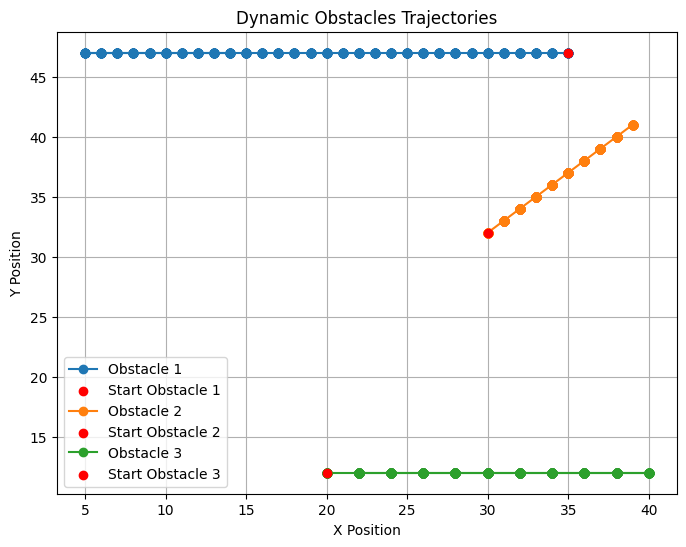

In [ ]:
dynamic_obstacles = [obs for obs in ENVIRONMENTS[0]['obstacles'] if 'velocity' in obs]

plt.figure(figsize=(8, 6))

# plot trajectory for each obstacle as defined in `ENVIRONMENT`
all_trajectories = []
for idx, obs in enumerate(dynamic_obstacles):
    trajectory = generate_obstacle_trajectory(
        initial_pos=obs['pos'],
        velocity=obs['velocity'],
        range_limits=obs['range'],
        steps=1000
    )
    all_trajectories.append(trajectory)
    plot_trajectory(trajectory, idx + 1)


plt.title("Dynamic Obstacles Trajectories")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.grid(True)
plt.legend()
plt.show()

### Prepare trajectory data for training

In [ ]:
def prepare_lstm_data(trajectories, history_length=HISTORY_LENGTH):
    """
    Prepares LSTM training data from obstacle trajectories.

    Parameters:
    - trajectories: List of [x, y] coordinates representing obstacle movement.
    - history_length: Number of time steps used as input.

    Returns:
    - X: Input sequence data for LSTM model, shape (num_samples, history_length, 2).
    - y: Target (next position), shape (num_samples, 2).
    """

    X, y = [], []

    for traj in trajectories:
        for i in range(len(traj) - history_length):
            X.append(traj[i:i+history_length])  # take `HISTORY_LEGTH` steps as input (h=25)
            y.append(traj[i+history_length])    # next step as target

    return np.array(X), np.array(y)

In [ ]:
all_trajectories = []
for obs in dynamic_obstacles:
    trajectory = generate_obstacle_trajectory(
        initial_pos=obs['pos'],
        velocity=obs['velocity'],
        range_limits=obs['range'],
        steps=1000
    )
    all_trajectories.append(trajectory)

In [ ]:
X_train, y_train = prepare_lstm_data(all_trajectories)

In [ ]:
X_train

array([[[35, 47],
        [34, 47],
        [33, 47],
        ...,
        [13, 47],
        [12, 47],
        [11, 47]],

       [[34, 47],
        [33, 47],
        [32, 47],
        ...,
        [12, 47],
        [11, 47],
        [10, 47]],

       [[33, 47],
        [32, 47],
        [31, 47],
        ...,
        [11, 47],
        [10, 47],
        [ 9, 47]],

       ...,

       [[36, 12],
        [34, 12],
        [32, 12],
        ...,
        [32, 12],
        [30, 12],
        [28, 12]],

       [[34, 12],
        [32, 12],
        [30, 12],
        ...,
        [30, 12],
        [28, 12],
        [26, 12]],

       [[32, 12],
        [30, 12],
        [28, 12],
        ...,
        [28, 12],
        [26, 12],
        [24, 12]]])

In [ ]:
y_train

array([[10, 47],
       [ 9, 47],
       [ 8, 47],
       ...,
       [26, 12],
       [24, 12],
       [22, 12]])

In [ ]:
X_train.shape, y_train.shape

((2925, 25, 2), (2925, 2))

### Train the `LSTM` Model

In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=8)

Epoch 1/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 384.8025
Epoch 2/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 48.3588
Epoch 3/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 42.6765
Epoch 4/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 3.4554
Epoch 5/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.2862
Epoch 6/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.1119
Epoch 7/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0959
Epoch 8/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1776
Epoch 9/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.1132
Epoch 10/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1525


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
save_dir = '/content/drive/My Drive/UAV-DRL_Saved Model'
model_name = 'lstm_model_latest'

In [ ]:
model.save(f"{save_dir}/{model_name}", save_format="tf")
model.save(f"{save_dir}/{model_name}.keras")
model.save(f"{save_dir}/{model_name}.h5")

In [ ]:
model = load_model(f"{save_dir}/{model_name}.keras")

In [ ]:
def predict_complete_trajectory(initial_trajectory, model, steps=100):
    history_length = HISTORY_LENGTH
    predicted_trajectory = []

    # using the last `history_length` points to initialize predictions
    input_seq = initial_trajectory[-history_length:].reshape(1, history_length, 2)

    for _ in range(steps):
        next_pos = model.predict(input_seq)  # predict the next position
        predicted_trajectory.append(next_pos[0])  # store the predicted position
        # update the input sequence with the new predicted position
        input_seq = np.append(input_seq[:, 1:, :], next_pos.reshape(1, 1, 2), axis=1)

    return np.array(predicted_trajectory)

### Testing the `LSTM` Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━

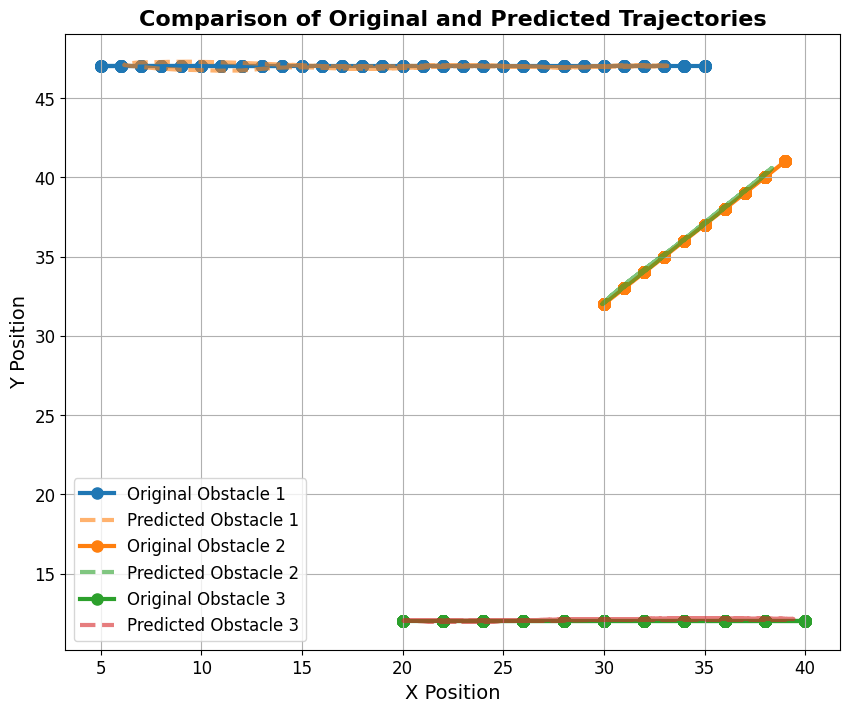

In [ ]:
# comparing original and predicted trajectories
plt.figure(figsize=(10, 8))

for idx, original_trajectory in enumerate(all_trajectories):
    predicted_trajectory = predict_complete_trajectory(original_trajectory, model, steps=100)

    # plot the original trajectory
    plt.plot(
             original_trajectory[:, 0],
             original_trajectory[:, 1],
             label=f'Original Obstacle {idx + 1}',
             marker='o',
             markersize=8,
             linewidth=3,
             color=f'C{idx}',
             zorder=1
             )

    # plot the predicted trajectory
    plt.plot(
            predicted_trajectory[:, 0],
            predicted_trajectory[:, 1],
            label=f'Predicted Obstacle {idx + 1}',
            linestyle='--', linewidth=3,
            color=f'C{idx+1}',
            alpha=0.6,
            zorder=2
            )

plt.title("Comparison of Original and Predicted Trajectories", fontsize=16, fontweight='bold')
plt.xlabel("X Position", fontsize=14)
plt.ylabel("Y Position", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Fucntion to see the pre-defined environments

In [ ]:
def plot_environment(env_idx: int) -> None:
    env = ENVIRONMENTS[env_idx]

    plt.figure(figsize=(10, 10))
    plt.xlim(0, GRID_SIZE[0])
    plt.ylim(0, GRID_SIZE[1])

    # Plot the Target
    plt.plot(env['target_pos'][0], env['target_pos'][1], 'go', markersize=50)

    # Plot the Target Radius
    target_circle = plt.Circle(env['target_pos'], TARGET_RADIUS, color='lightgreen', alpha=0.5)
    plt.gca().add_patch(target_circle)

    # Plot the UAV start position
    plt.plot(env['start_pos'][0], env['start_pos'][1], 'bo', markersize=10, label='UAV Start')

    # Plot all the Obstacles
    for obs in env['obstacles']:
        if 'velocity' in obs:  # If velocity exists, it's a dynamic obstacle
            obstacle_circle = plt.Circle(obs['pos'], obs['rad'], color='orange', alpha=0.7, label='Dynamic Obstacle')
        else:  # Otherwise, it's a static obstacle
            obstacle_circle = plt.Circle(obs['pos'], obs['rad'], color='r', alpha=0.7, label='Static Obstacle')
        plt.gca().add_patch(obstacle_circle)

    # Add proxy artists for the legend
    target_proxy = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='g', markersize=10, alpha=0.7, label='Target')
    dynamic_proxy = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Dynamic Obstacle')
    static_proxy = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10, label='Static Obstacle')

    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title(f'UAV Environment: {env_idx}')
    plt.grid(True)
    plt.legend(handles=[target_proxy, dynamic_proxy, static_proxy, plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10, label='UAV Start')])
    plt.show()

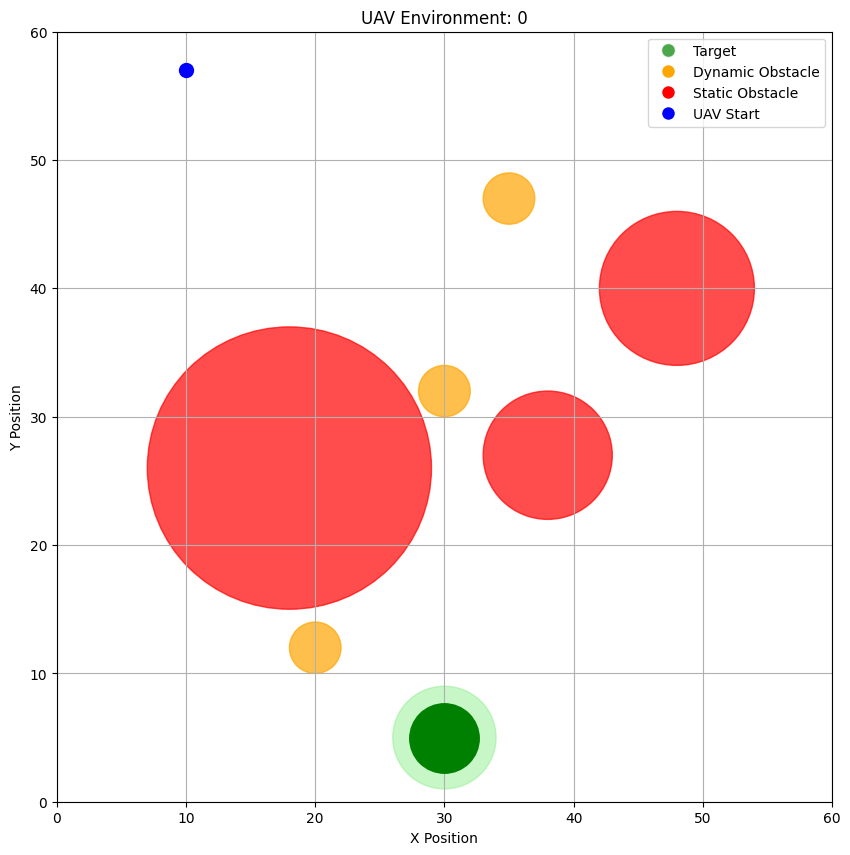

In [ ]:
plot_environment(0)

## Function to visualize the environment during training

In [ ]:
def visualize_environment(env: 'UAVEnvironment', path: List[np.ndarray]) -> None:
    plt.figure(figsize=(10, 10))
    plt.xlim(0, env.grid_size[0])
    plt.ylim(0, env.grid_size[1])

    # Plot the Target
    plt.plot(env.target_position[0], env.target_position[1], 'go', markersize=50)

    # Plot the Target Radius
    target_circle = plt.Circle(env.target_position, TARGET_RADIUS, color='lightgreen', alpha=0.5)
    plt.gca().add_patch(target_circle)

    # Plot all the Obstacles
    for i, obs in enumerate(env.obstacles):
        if 'velocity' in obs:
            obstacle_circle = plt.Circle(obs['pos'], obs['rad'], color='orange', alpha=0.7, label='Dynamic Obstacle' if i == len(env.obstacles) - 1 else "")
        else:
            obstacle_circle = plt.Circle(obs['pos'], obs['rad'], color='r', alpha=0.7, label='Static Obstacle' if i == len(env.obstacles) - 1 else "")
        plt.gca().add_patch(obstacle_circle)

    # Plot the UAVs path
    path = np.array(path)
    plt.plot(path[:, 0], path[:, 1], 'bo-')

    # Plot the UAVs start position
    plt.plot(path[0, 0], path[0, 1], 'ro')

    # Add proxy artists for the legend
    target_proxy = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='g', markersize=10, label='Target')
    dynamic_proxy = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Dynamic Obstacle')
    static_proxy = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10, label='Static Obstacle')

    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('UAV Path and Environment')

    plt.grid(True)
    plt.legend(handles=[target_proxy, dynamic_proxy, static_proxy, plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10, label='UAV Path Start')])
    plt.show()

## Custom OpenAI Gym UAV Environment

In [ ]:
class UAVEnvironment(gym.Env):
    def __init__(self, grid_size: Tuple[int, int], max_steps: int, env_config: Dict) -> None:
        super(UAVEnvironment, self).__init__()

        # The size (dimensions) of the training environment and
        # maximum steps that the UAV can take in single episode
        self.grid_size = grid_size
        self.max_steps = max_steps
        self.current_step = 0
        self.terminal_state = None

        # Directions that the UAV can go in
        self.directions = {
            'north': [0, 1],
            'south': [0, -1],
            'east': [1, 0],
            'west': [-1, 0],
            'northwest':[-1, 1],
            'northeast': [1, 1],
            'southwest': [-1, -1],
            'southeast': [1, -1]
        }

        # Action space: 8 possible movements
        self.action_space = spaces.Discrete(8)

        # Observation space: position of UAV in the grid
        self.observation_space = spaces.Box(
            low=np.array([0, 0]),
            high=np.array(GRID_SIZE),
            shape=(2,),
            dtype=np.int32
        )

       # initializing the environment
        self.env_config = env_config
        self.uav_position = np.array(self.env_config['start_pos'])
        self.target_position = np.array(self.env_config['target_pos'])
        self.obstacles = self.env_config['obstacles']

        # list to store the path taken by UAV (used in visualization)
        self.uav_path = []

        # storing dynamic obstacle's previous positions (deque with specified max length for each dynamic obstacle)
        self.dynamic_obstacles = [obs for obs in self.obstacles if 'velocity' in obs]


    # Method to move dynamic obstacles in the environment
    def move_dynamic_obstacles(self):
        # Iterate over each obstacle in the obstacle list
        for idx, obstacle in enumerate(self.dynamic_obstacles):
            # get the current position of the obstacle as a numpy array (x, y coordinates)
            pos = np.array(obstacle['pos'])
             # get the velocity of the obstacle as a numpy array (change in x and y per movement)
            velocity = np.array(obstacle['velocity'])
            if 'range' in obstacle:
                # If the range is a single pair of min and max values then it is 1D
                if isinstance(obstacle['range'][0], int):
                    min_range, max_range = obstacle['range']
                    if pos[0] + velocity[0] > max_range or pos[0] + velocity[0] < min_range:
                        velocity[0] *= -1
                else:
                    # If the range is 2D (pairs of x and y boundaries)
                    min_range_x, max_range_x = obstacle['range'][0]
                    min_range_y, max_range_y = obstacle['range'][1]
                    # Check if the new position (after adding velocity) will exceed the boundaries in both x and y
                    if (pos[0] + velocity[0] > max_range_x or pos[0] + velocity[0] < min_range_x)\
                            and (pos[1] + velocity[1] > max_range_y or pos[1] + velocity[1] < min_range_y):
                        velocity[0] *= -1 # Reverse direction on x-axis
                        velocity[1] *= -1 # Reverse direction on y-axis

            # Update the position by adding the velocity to the current position and convert back to list
            obstacle['pos'] = (pos + velocity).tolist()
            # Update the velocity in the obstacle dictionary
            obstacle['velocity'] = velocity.tolist()


    # Method to reset the environment after each episode end
    def reset(self) -> np.ndarray:
        self.current_step = 0
        self.uav_position = np.array(self.env_config['start_pos'])
        self.uav_path = [self.uav_position.copy()]

        # reset dynamic obstacles positions and velocities
        for obstacle in self.dynamic_obstacles:
            obstacle['pos'] = obstacle['pos']

        self.terminal_state = None
        return self.uav_position


    def step(self, action: int) -> Tuple[np.ndarray, float, bool, Dict]:
        self.current_step += 1
        movement = {
            0: np.array(self.directions['north']),
            1: np.array(self.directions['south']),
            2: np.array(self.directions['west']),
            3: np.array(self.directions['east']),
            4: np.array(self.directions['northwest']),
            5: np.array(self.directions['northeast']),
            6: np.array(self.directions['southwest']),
            7: np.array(self.directions['southeast'])
        }[action]

        # ensuring that the UAV remains within the grid boundaries, preventing it from moving out of bounds.
        self.uav_position = np.clip(self.uav_position + movement, 0, np.array(self.grid_size) - 1)
        self.uav_path.append(self.uav_position.copy())

        # move the dynamic obstacle
        self.move_dynamic_obstacles()

        # calculate the reward and check if the episode is done or not
        reward = self.calc_reward()
        done = self.is_done()
        info = {'terminal_state': self.terminal_state} if done else {}

        return self.uav_position, reward, done, info


    # Method to Check whether the UAV is to left of the target
    def is_left(self) -> bool:
        uav_x, _ = self.uav_position
        target_x, _ = self.target_position
        return uav_x < target_x


    # Method to Check whether the UAV is above the target
    def is_up(self) -> bool:
        _, uav_y = self.uav_position
        _, target_y = self.target_position
        return uav_y > target_y


    def select_action(self) -> int:
        # --------- Heuristic action selection policy based on 'Algorithm 1' in the article ---------- #

        # 10% chance to explore randomly
        if np.random.rand() < 0.1:
            return np.random.randint(0, 8)

        # 90% to explore according to the policy defined below
        if self.is_left():
            if self.is_up():
                a = np.random.choice([1, 3, 5, 6, 7])
            else:
                a = np.random.choice([0, 3, 4, 5, 7])
        else:
            if self.is_up():
                a = np.random.choice([1, 2, 4, 6, 7])
            else:
                a = np.random.choice([0, 2, 4, 5, 6])
        return a


    # Method to calculate the reward for the UAV agent based on its actions
    def calc_reward(self) -> float:
        reward = 0

        # 1. Distance to Goal
        distance_to_goal = np.linalg.norm(self.uav_position - self.target_position)
        reward -= 0.1 * distance_to_goal  # Small penalty proportional to the distance to encourage movement towards the goal

        # 2. Goal Achievement Reward
        if np.linalg.norm(self.uav_position - self.target_position) <= TARGET_RADIUS:
            reward += 100
            return reward

        # 3. Obstacle Avoidance
        for obstacle in self.obstacles:
            distance_to_obstacle = np.linalg.norm(self.uav_position - obstacle['pos'])
            if distance_to_obstacle < obstacle['rad']:
                reward -= 50

        # 4. Efficiency Penalty (Small penalty for each step to encourage faster completion)
        reward -= 0.05

        return reward


    # Method to check whether the episode is ended or not
    def is_done(self) -> bool:
        # 1. Goal Achievement
        if np.linalg.norm(self.uav_position - self.target_position) <= TARGET_RADIUS:
            print("Target Reached")
            self.terminal_state = 'finish'
            return True

        # 2. Collision with Obstacle
        for obstacle in self.obstacles:
            if np.linalg.norm(self.uav_position - obstacle['pos']) < obstacle['rad']:
                print("Collided")
                self.terminal_state = 'collision'
                return True

        # 3. Maximum Steps Reached
        if self.current_step >= self.max_steps:
            print("Max steps exceed")
            self.terminal_state = 'out_of_steps'
            return True

        return False


    # Method to see visualization of the environment during training/testing
    def render(self, mode='human'):
        visualize_environment(self, self.uav_path)

## Testing RL environment

Initial State: [10 57]
Action: 7
Next State: [11 56], Reward: -5.492425929675111, Done: False, Info: {}


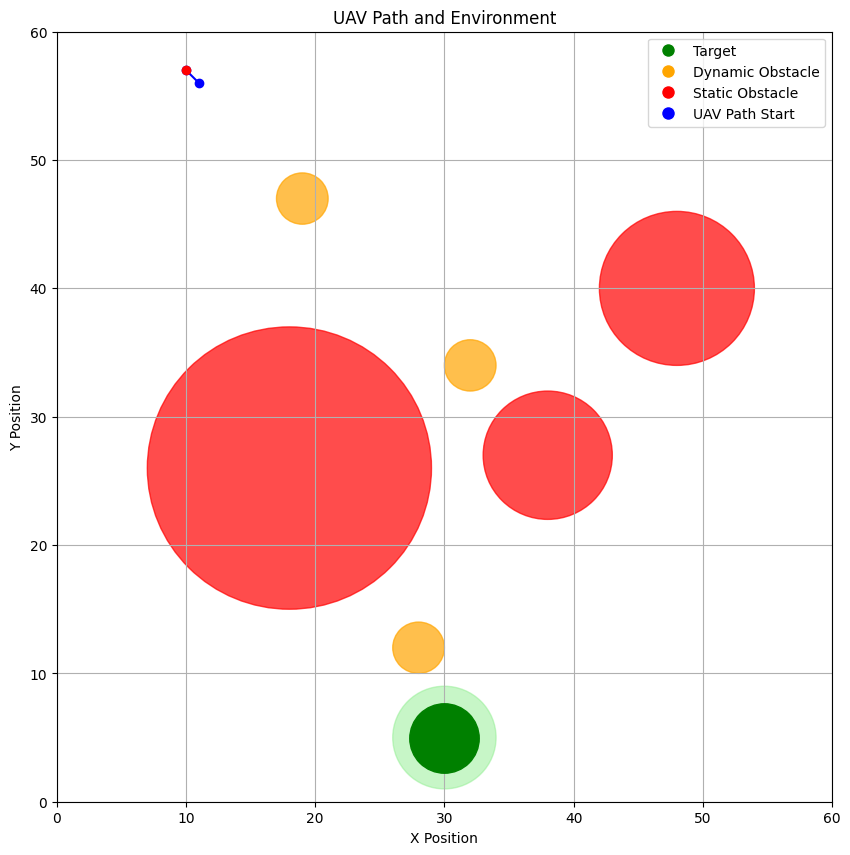

Action: 7
Next State: [12 55], Reward: -5.36413210223457, Done: False, Info: {}


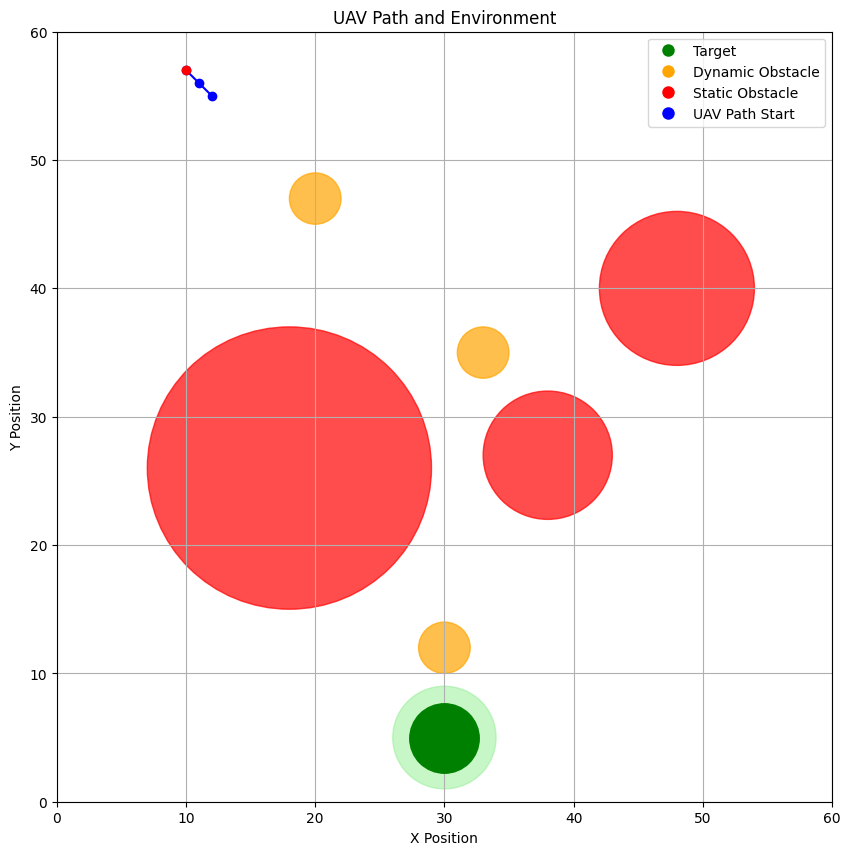

Action: 2
Next State: [11 55], Reward: -5.398831648126533, Done: False, Info: {}


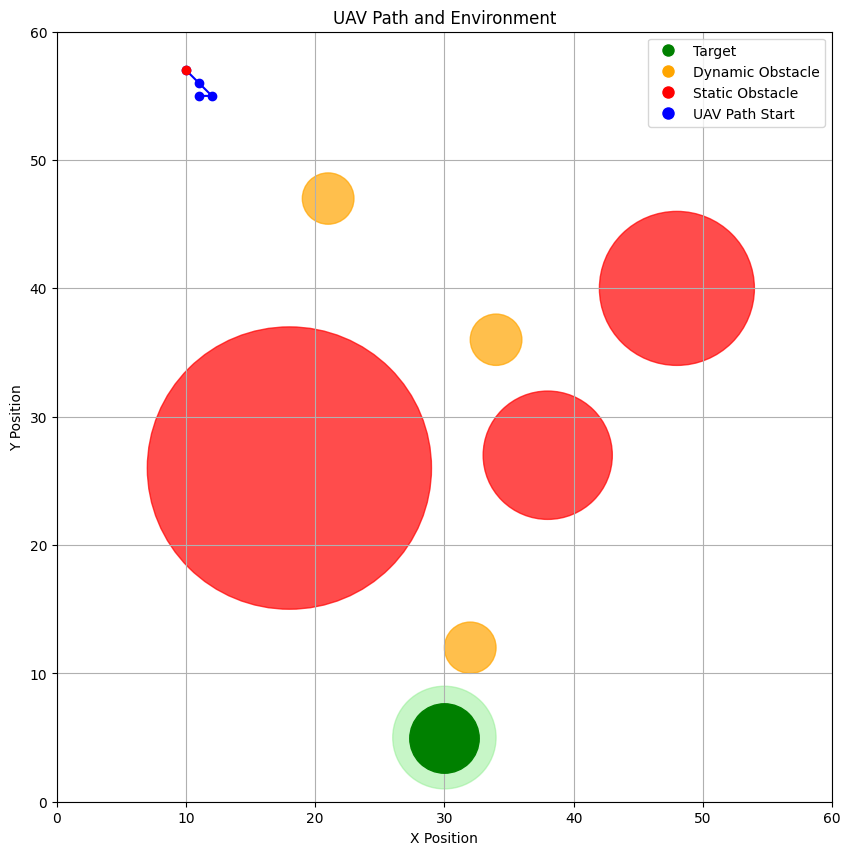

Action: 3
Next State: [12 55], Reward: -5.36413210223457, Done: False, Info: {}


KeyboardInterrupt: 

In [ ]:
# Initialize UAVEnvironment class
env = UAVEnvironment(grid_size=GRID_SIZE, max_steps=MAX_STEPS, env_config=ENVIRONMENTS[0])

# Resetting the environment to start a new episode
state = env.reset()
print(f"Initial State: {state}")

# Running a test episode
done = False
total_reward = 0

while not done:
    # Select an action
    action = env.select_action()
    print(f"Action: {action}")

    # Take a step in the environment
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    print(f"Next State: {next_state}, Reward: {reward}, Done: {done}, Info: {info}")

    # Render the environment
    env.render()

print(f"Total Reward: {total_reward}")
print("Episode finished.")

# **Part (B) - Building a Neural Network D3QN Agent**

## Uninstall tensorflow 2.17

In [ ]:
!pip uninstall -y tensorflow

## Install tensorflow 2.15 & keras-rl2

In [ ]:
!pip install tensorflow==2.15 keras-rl2

## Import dependencies

In [2]:
tf.keras.__version__ = tf.__version__

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from tensorflow.keras.optimizers.legacy import Adam
from rl.agents.dqn import DQNAgent
from rl.policy import Policy
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory
from keras.callbacks import Callback
from keras.src.saving import serialization_lib

In [4]:
serialization_lib.enable_unsafe_deserialization()

## Neural Network Architecture for D3QN

In [ ]:
def build_model(actions: int, input_shape: Tuple[int, ...]) -> Sequential:
    model = Sequential()
    model.add(Flatten(input_shape=(1,) + input_shape))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

## Custom RL Policy

In [ ]:
class CustomPolicy(Policy):
    def __init__(self, env: 'UAVEnvironment'):
      super(CustomPolicy, self).__init__()
      self.env = env

    def select_action(self, **kwargs):
      return self.env.select_action()

## Define `CustomPolicy`, `memory` and `DQNAgent` instances and build a DQN Agent

In [ ]:
def build_agent(model: Sequential, actions: int) -> DQNAgent:
    policy = EpsGreedyQPolicy()
    memory = SequentialMemory(limit=REPLAY_MEMORY_CAPACITY, window_length=1)
    d3qn = DQNAgent(
                    model=model,
                    memory=memory,
                    policy=policy,
                    nb_actions=actions,
                    nb_steps_warmup=PRE_TRAINING_ROUNDS,
                    batch_size=MINIBATCH_SIZE,
                    gamma=DISCOUNT_FACTOR,
                    target_model_update=TARGET_NETWORK_UPDATE_RATE,
                    enable_double_dqn=True,
                    enable_dueling_network=True,
                    dueling_type='avg'
                  )
    return d3qn

## Initialize the `UAVEnvironment` Class

In [ ]:
env = UAVEnvironment(grid_size=GRID_SIZE, max_steps=MAX_STEPS, env_config=ENVIRONMENTS[0])
actions = env.action_space.n
input_shape = env.observation_space.shape

print(actions)
print(input_shape)
print(MAX_STEPS)
print(GRID_SIZE)

8
(2,)
500
(60, 60)


## Build and Compile the `DQN` model

In [ ]:
model = build_model(actions, input_shape)
d3qn = build_agent(model, actions)
d3qn.compile(Adam(Q_NETWORK_LEARNING_RATE), metrics=['mae'])

## Custom Training Logger Callback

In [ ]:
class TerminalStateLogger(Callback):
    def __init__(self, env: 'UAVEnvironment'):
        super(TerminalStateLogger).__init__()
        self.env = env

        self.terminal_states = {
            'out_of_steps': [],
            'collision': [],
            'finish': []
        }
        self.episode_count = 0

    def on_episode_end(self, episode, logs):
        self.episode_count += 1
        terminal_state = env.terminal_state
        self.terminal_states['out_of_steps'].append(1 if terminal_state == 'out_of_steps' else 0)
        self.terminal_states['collision'].append(1 if terminal_state == 'collision' else 0)
        self.terminal_states['finish'].append(1 if terminal_state == 'finish' else 0)

    def plot_terminal_states(self):
        episodes = range(1, self.episode_count + 1)
        plt.figure(figsize=(10, 6))
        plt.plot(episodes, np.cumsum(self.terminal_states['out_of_steps']), label='out of steps', color='blue')
        plt.plot(episodes, np.cumsum(self.terminal_states['collision']), label='collision', color='green')
        plt.plot(episodes, np.cumsum(self.terminal_states['finish']), label='finish', color='red')
        plt.xlabel('Episodes')
        plt.ylabel('Terminal State (%)')
        plt.legend()
        plt.show()

In [ ]:
terminal_state_logger = TerminalStateLogger(env)

# **Part (C) Training the Agent**

## Train the Agent

In [ ]:
d3qn.fit(env, nb_steps=50000, visualize=False, verbose=1, callbacks=[terminal_state_logger])

In [ ]:
terminal_state_logger.plot_terminal_states()

## Save the model weights

In [ ]:
d3qn.save_weights('d3qn_weights.h5f', overwrite=True)

## Test the trained Model

In [ ]:
d3qn.test(env, nb_episodes=10, visualize=False)